In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF
from safetensors.torch import load_file
from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    UniPCMultistepScheduler,
)
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt
# your classes
from flownet import DualFlowControlNet
from pipeline import StableDiffusionDualFlowControlNetPipeline

/data/maryamsana_98/anaconda3/envs/diffusers_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/maryamsana_98/anaconda3/envs/diffusers_env/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/data/maryamsana_98/anaconda3/envs/diffusers_env/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::fla

In [2]:
# ---------------------------
# Helpers: image & .flo loaders
# ---------------------------
def read_flo(path: str) -> np.ndarray:
    """Middlebury .flo → [H,W,2] float32 (pixel units)."""
    with open(path, "rb") as f:
        magic = np.fromfile(f, np.float32, 1)[0]
        if magic != 202021.25:
            raise ValueError(f"Invalid .flo file: {path} (magic={magic})")
        w = int(np.fromfile(f, np.int32, 1)[0])
        h = int(np.fromfile(f, np.int32, 1)[0])
        data = np.fromfile(f, np.float32, 2 * w * h).reshape(h, w, 2)
    return data

def resize_flow_to(flow_hw2: np.ndarray, target_h: int, target_w: int) -> torch.Tensor:
    """Resize flow with bilinear and scale vectors to remain in pixel units."""
    ft = torch.from_numpy(flow_hw2).permute(2, 0, 1).unsqueeze(0)  # [1,2,H,W]
    _, _, H, W = ft.shape
    ft = F.interpolate(ft, size=(target_h, target_w), mode="bilinear", align_corners=True)
    ft[:, 0] *= (target_w / max(W, 1))
    ft[:, 1] *= (target_h / max(H, 1))
    return ft  # [1,2,target_h,target_w]

def load_pair_to_sixch(path0, path1, size=(512, 512)) -> torch.Tensor:
    """Two RGB images → [1,6,H,W] in [0,1]."""
    def load_rgb(p):
        img = Image.open(p).convert("RGB")
        if size is not None:
            img = img.resize(size, Image.BICUBIC)
        return TF.to_tensor(img)  # [3,H,W], float32
    a = load_rgb(path0)
    b = load_rgb(path1)
    return torch.cat([a, b], dim=0).unsqueeze(0)  # [1,6,H,W]

def load_controls_and_flows(
    img0_path, img1_path, fwd_flo_path, bwd_flo_path, size=(512, 512), device="cuda", dtype=torch.float32
):
    H, W = size
    sixch = load_pair_to_sixch(img0_path, img1_path, size=size).to(device=device, dtype=dtype)  # [1,6,H,W]

    fwd = read_flo(fwd_flo_path)
    bwd = read_flo(bwd_flo_path)
    fwd_t = resize_flow_to(fwd, H, W)
    bwd_t = resize_flow_to(bwd, H, W)
    flow4 = torch.cat([fwd_t, bwd_t], dim=1).to(device=device, dtype=dtype)  # [1,4,H,W]
    return sixch, flow4


In [3]:
device = "cuda"
dtype  = torch.float32 
# ---------------------------
# Load controls
# ---------------------------
sixch, flow4 = load_controls_and_flows(
    "data/Beauty/images/frame_0000.png",
    "data/Beauty/images/frame_0002.png",
    "data/Beauty/optical_flow/optical_flow_gop_2_raft/flow_0000_0001.flo",
    "data/Beauty/optical_flow_bwd/optical_flow_gop_2_raft/flow_0002_0001.flo",
    size=(512, 512),
    device=device,
    dtype=dtype,
)

In [4]:
# ---------------------------
# Load models (aligned SD-1.5)
# ---------------------------
base = "stable-diffusion-v1-5/stable-diffusion-v1-5"

vae = AutoencoderKL.from_pretrained(base, subfolder="vae", torch_dtype=dtype)
unet = UNet2DConditionModel.from_pretrained(base, subfolder="unet", torch_dtype=dtype)
text_encoder = CLIPTextModel.from_pretrained(base, subfolder="text_encoder", torch_dtype=dtype)
tokenizer = CLIPTokenizer.from_pretrained(base, subfolder="tokenizer")
scheduler = UniPCMultistepScheduler.from_pretrained(base, subfolder="scheduler")

# --- ControlNet: load your subclass weights ---
controlnet = DualFlowControlNet(
    block_out_channels=tuple(unet.config.block_out_channels),     # (320, 640, 1280, 1280)
    layers_per_block=2,
    cross_attention_dim=768,   
 )
# controlnet.load_state_dict(torch.load("path/to/controlnet.safetensors" or ".pth", map_location="cpu"))

# sanity: cross-attn dims must match (768 for SD1.x)
assert unet.config.cross_attention_dim == text_encoder.config.hidden_size == 768
if hasattr(controlnet, "config") and hasattr(controlnet.config, "cross_attention_dim"):
    assert controlnet.config.cross_attention_dim == 768, f"ControlNet CAD={controlnet.config.cross_attention_dim}"

In [5]:
ckpt = load_file('experiments/controlnet/checkpoint-11500/controlnet/diffusion_pytorch_model.safetensors')
controlnet.load_state_dict(ckpt,strict=False)

<All keys matched successfully>

In [6]:
# ---------------------------
# Inference
# ---------------------------
prompt = "a pretty girl smiling , has pink lipstick and is infront of black background"
g = torch.Generator(device=device).manual_seed(42)  

In [8]:
# -------------------
# 1. Encode text
# -------------------
text_inputs = tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)
input_ids = text_inputs.input_ids.to(device)
text_encoder = text_encoder.to(device)
encoder_hidden_states = text_encoder(input_ids)[0]

# classifier-free guidance: duplicate text encodings
uncond_inputs = tokenizer(
    [""] * input_ids.shape[0],
    padding="max_length",
    max_length=tokenizer.model_max_length,
    return_tensors="pt",
)
uncond_ids = uncond_inputs.input_ids.to(device)
uncond_embeds = text_encoder(uncond_ids)[0]
encoder_hidden_states = torch.cat([uncond_embeds, encoder_hidden_states], dim=0)

# -------------------
# 2. Prepare latents
# -------------------
latent_shape = (input_ids.shape[0], unet.in_channels, 64 , 64 )
latents = torch.randn(latent_shape, device=device, dtype=dtype)

# scale by scheduler
scheduler.set_timesteps(50, device=device)
latents = latents * scheduler.init_noise_sigma

/tmp/ipykernel_1043632/130234068.py:29: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latent_shape = (input_ids.shape[0], unet.in_channels, 64 , 64 )


In [ ]:
# del ckpt, tokenizer, text_encoder
torch.cuda.empty_cache()

In [9]:
controlnet = controlnet.to(device)
unet = unet.to(device)
guidance_scale = 7.5

In [32]:
t= scheduler.timesteps[3]

In [33]:
latents.shape

torch.Size([2, 4, 64, 64])

In [34]:
latent_model_input = torch.cat([latents] * 2)

# predict ControlNet residuals
down_res, mid_res = controlnet(
    latent_model_input,
    t,
    encoder_hidden_states=encoder_hidden_states,
    controlnet_cond=sixch,
    flow_cond=flow4,
    return_dict=False,
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 13.25 MiB is free. Including non-PyTorch memory, this process has 23.66 GiB memory in use. Of the allocated memory 23.21 GiB is allocated by PyTorch, and 206.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [14]:
noise_pred = unet(
        latent_model_input,
        t,
        encoder_hidden_states=encoder_hidden_states,
        down_block_additional_residuals=[
            s.to(dtype) for s in down_res
        ],
        mid_block_additional_residual=mid_res.to(dtype),
    ).sample

In [15]:
noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

# scheduler update
latents = scheduler.step(noise_pred, t, latents).prev_sample

In [17]:
vae = vae.to(device )

In [29]:
latents = latents / vae.config.scaling_factor
image = vae.decode(latents).sample
image = (image / 2 + 0.5).clamp(0, 1)   # to [0,1]

In [30]:
latents = scheduler.step(noise_pred, t, latents).prev_sample

In [ ]:
# -------------------
# 3. Denoising loop
# -------------------
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # duplicate latents for guidance
    latent_model_input = torch.cat([latents] * 2)

    # predict ControlNet residuals
    down_res, mid_res = controlnet(
        latent_model_input,
        t,
        encoder_hidden_states=encoder_hidden_states,
        controlnet_cond=sixch,
        flow_cond=flow4,
        return_dict=False,
    )

    # UNet prediction with ControlNet residuals
    noise_pred = unet(
        latent_model_input,
        t,
        encoder_hidden_states=encoder_hidden_states,
        down_block_additional_residuals=[
            s.to(dtype) for s in down_res
        ],
        mid_block_additional_residual=mid_res.to(dtype),
    ).sample

    # classifier-free guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # scheduler update
    latents = scheduler.step(noise_pred, t, latents).prev_sample

# -------------------
# 4. Decode latents
# -------------------
latents = latents / vae.config.scaling_factor
image = vae.decode(latents).sample
image = (image / 2 + 0.5).clamp(0, 1)   # to [0,1]

In [27]:
latents =  latent_model_input - noise_pred

latents = latents / vae.config.scaling_factor
image = vae.decode(latents).sample
image = (image / 2 + 0.5).clamp(0, 1) 

image = image.detach().cpu().permute(0, 2, 3, 1).numpy()  # BCHW -> BHWC
plt.imshow(image[0])

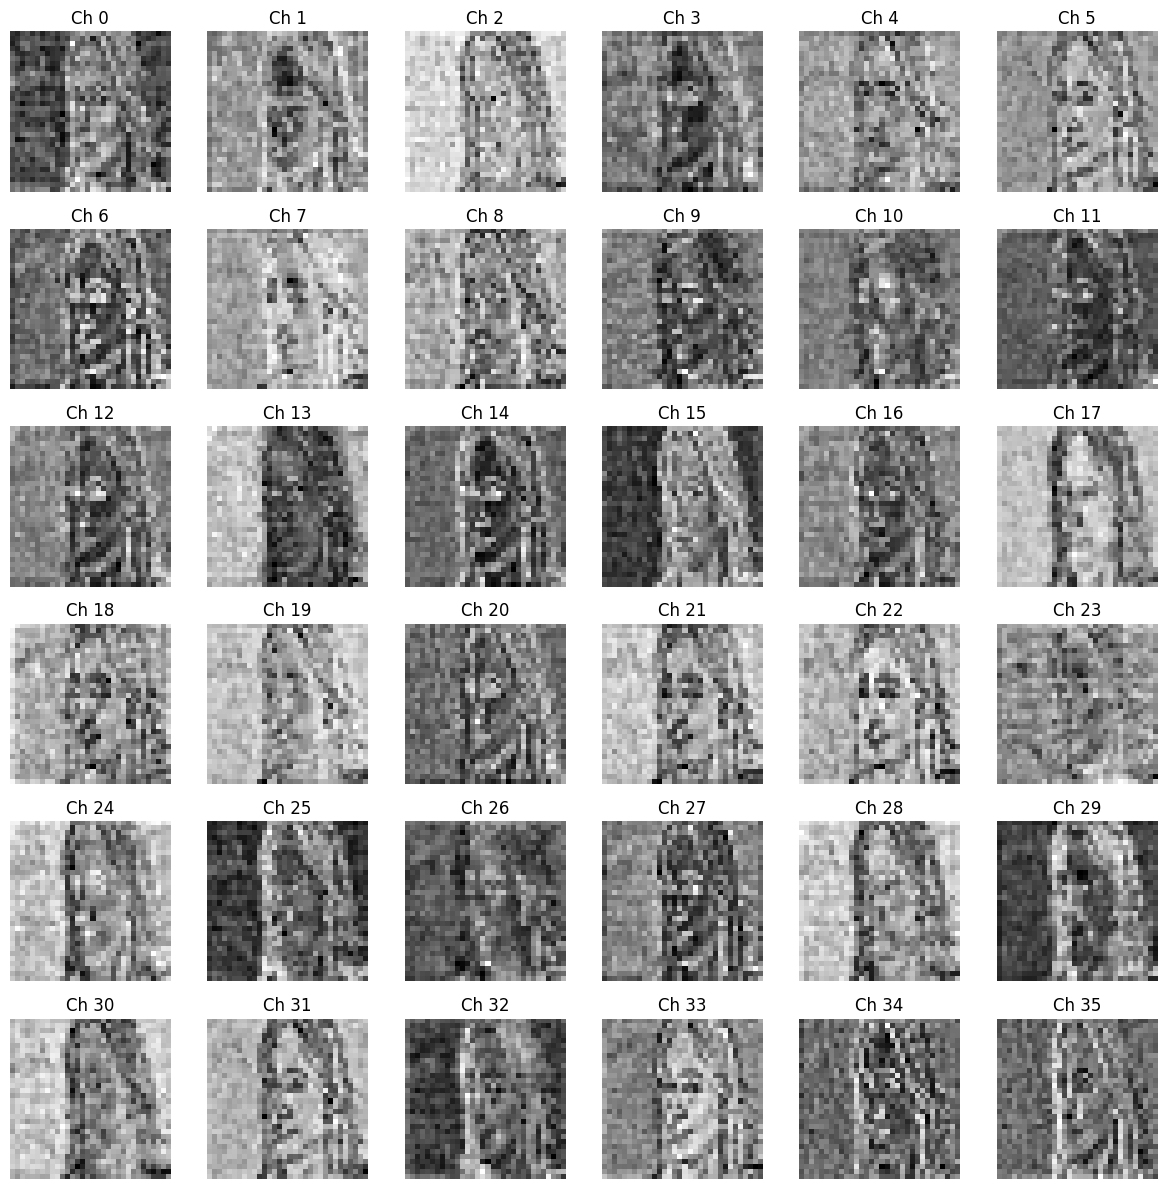

In [26]:
import matplotlib.pyplot as plt
x = down_res[5]

# Select the first item in batch
feature_maps = x[0]

# Choose how many maps to display (e.g., 16)
n_maps = 36 
fig, axes = plt.subplots(6, 6, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    fmap = feature_maps[i].detach().cpu().numpy()
    ax.imshow(fmap, cmap="gray")  # or "gray"
    ax.axis("off")
    ax.set_title(f"Ch {i}")

plt.tight_layout()
plt.show()
